# <center>Semi-Supervised Generative Adversarial Networks on Text Data</center>
In this notebook, we'll learn how to use GANs to do semi-supervised learning in text data. <br />

In supervised learning, we have a training set of inputs $x$ and class labels $y$. We train a model that takes $x$ as input and gives $y$ as output. <br /> 

In semi-supervised learning, the goal is still to train a model that takes x as input and generates y as output.<br /><br />
**Problem**: In many machine learning applications, not all of training examples have a label y. Hence, the goal here is to develop an algorithm that is able to get better at classification by studying both labeled (x,y) pairs and unlabeled x examples.
<br />
## GAN
GAN (Generative Adversarial Network) are neural networks proposed by Ian Goodfellow, Yoshua Bengio and others in 2014[[1]](#cite-goodfellow2014generative) which composed up of two networks competing with each other.

The two networks namely,

* generator — generate data 
* discriminator — to validate the data set. 

The goal is to generate data points that are similar to some of the data points in the training set.

### Discriminative Network
This network tries to tell the difference between the real and the fake data generated by the generator net.
![alt text](./images/discriminative.png)

### Generative Network
* The goal of the generative model is to find a $P_{model}(x)$  that approximates $P_{data}(x)$ well

![alt text](./images/generative.png)

### Objective Function
![alt text](./images/objective.png)

* $D(x)$ represents the probability of that $x$ came from the real data

* $D(G(z))$ represents the probability of that $z$ came from the fake data

* $P_{data}(x)$ represents the probabilty distribution of actual data

* $P_{model}(x)$ represents the text generated by the model
 
## Semi-Supervised GAN (SGAN)
* Discriminator$(D)$ in a GAN's is replaced with a $(k+1)$ classiifer where it receives a data point $x$ as input and outputs a $(k+1)$ dimensional vector of logits. These logits can then be transferred into class probabilities.
![alt text](./images/sdiscriminative.png)
![alt text](./images/sgenerative.png)

# Imports
* Python library Keras is used to classify Reuters dataset
    * tensorflow-gpu==1.8.0
    * keras==2.2.0

* The problem we are trying to solve here is to classify reuters newswires, into their 46 different topics, each topic has at least 10 examples in the training set.

In [1]:
from __future__ import division

import sys

import time
from datetime import timedelta

from tabulate import tabulate

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.model_selection import KFold, train_test_split

from keras.datasets import reuters
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv1D, GlobalMaxPooling1D, Flatten, UpSampling1D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

Using TensorFlow backend.


# Parameters

In [2]:
num_words = 100

latent_dim = 100
txt_rows = num_words

optimizer = Adam(0.0002, 0.5)
txt_cols = 1
txt_shape = (txt_rows, txt_cols)
num_classes = 46

# Data Loading
The Reuters dataset comes pre-loaded in Keras, in the form of a set of four Numpy arrays:

In [3]:
(x_data, y_data), __ = reuters.load_data(num_words=num_words, test_split=0)

The argument num_words=100 means that we will only keep the top 100 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.

x_data and y_data form the "training set", the data that the model will learn from. We have tested the model with 10-fold cross validation and hence haven't load the test set data. The text are encoded as Numpy arrays, and the labels are simply an array of digits, ranging from 0 to 45. 

Let's have a look at the training data:

In [4]:
print x_data.shape
print x_data[0]
print
print y_data.shape
print y_data[:5]
print
print np.unique(y_data)

(11228,)
[1, 2, 2, 8, 43, 10, 2, 5, 25, 2, 2, 5, 2, 2, 16, 2, 2, 90, 67, 7, 89, 5, 19, 2, 6, 19, 2, 15, 90, 67, 84, 22, 2, 26, 7, 48, 4, 49, 8, 2, 39, 2, 2, 6, 2, 6, 83, 11, 15, 22, 2, 11, 15, 7, 48, 9, 2, 2, 2, 6, 2, 6, 2, 11, 15, 22, 2, 44, 11, 15, 16, 8, 2, 2, 90, 67, 52, 29, 2, 30, 32, 2, 6, 2, 15, 17, 12]

(11228,)
[3 4 3 4 4]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


# Data Preprocessing
* Text consists in associating a unique integer index to every word, then turning this integer index i into a binary vector of size N, the size of the vocabulary, that would be all-zeros except for the i-th entry, which would be 1.

* We have used one-hot-encode our lists to turn them into vectors of 0s and 1s.

* One-hot encoding example,
![alt text](./images/one-hot.png)
<center>Source: Jon Krohn untapt Safari Live Lessons</center>


* Before training, we will preprocess our data by reshaping it into the shape that the network expects.

In [5]:
def vectorize_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # Sets specific indices of results[i] to 1s
    return results

In [6]:
x_data = vectorize_sequences(x_data, num_words)  # vectorized training data
x_data = np.expand_dims(x_data, axis=3)

y_data = y_data.reshape(-1, 1)

/home/tntech.edu/rsingh43/virtualenv/sgan-text/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [7]:
print x_data.shape
print y_data.shape

(11228, 100, 1)
(11228, 1)


# Discriminator Network
* First we will present discriminator network which will be train with the training data, real text, real labels, fake text and fake labels. The network will then learn to associate text and labels. Finally, we will ask the network to produce predictions for test data, and we will verify if these predictions match the labels from test_labels.

 ## Conv1D layer
* input: 3D tensor of shape (batch_size, steps, input_dim)

* output: 3D tensor of shape (batch_size, new_steps, filters)

* input_shape is sequence of 100 vectors of 1-dimensional vectors

 ## Dense layers
* We are ending the network with two Dense layer of size 1 and 46. This means that for each input sample, network will have two output a 1-dimensional vector and 46-dimensional vector. Each entry in 46-dimension vector (each dimension) will encode a different output class.

* The last layer is a 46-way "softmax" layer, which means it will return an array of 46 probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of our 46 topic classes.

In [8]:
def build_discriminator(txt_shape, num_classes, print_summary=False):
    model = Sequential()
    # apply a convolution 1d of length 3 to a sequence with 100 timesteps,
    # with 32 output filters
    model.add(Conv1D(32, kernel_size=3, strides=1, input_shape=txt_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    # add a new conv1d on top
    model.add(Conv1D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())

    if print_summary:
        model.summary()

    txt = Input(shape=txt_shape)

    features = model(txt)
    valid = Dense(1, activation="sigmoid")(features)
    label = Dense(num_classes+1, activation="softmax")(features)

    return Model(txt, [valid, label])

discriminator = build_discriminator(txt_shape, num_classes, True)
discriminator.compile(loss=['binary_crossentropy', 'categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 32)           128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 256)          24832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 100, 256)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
Total para

# Generator Network

In [9]:
def build_generator(latent_dim, num_words, print_summary=False):
    
    model = Sequential()

    model.add(Dense(128 * 50, activation="relu", input_dim=latent_dim))
    model.add(Reshape((50, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling1D())

    model.add(Conv1D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    if print_summary:
        model.summary()

    noise = Input(shape=(latent_dim,))
    txt = model(noise)

    return Model(noise, txt)

generator = build_generator(latent_dim, num_words, True)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6400)              646400    
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 128)           512       
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 100, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 1)            385       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 1)            0         
Total params: 647,297
Trainable params: 647,041
Non-trainable params: 256
_________________________________________________________________
__

# Combined Model

In [10]:
# The generator takes noise as input and generates txt
noise = Input(shape=(num_words,))
txt = generator(noise)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid, _ = discriminator(txt)

# The combined model  (stacked generator and discriminator)
# Trains generator to fool discriminator
combined = Model(noise , valid)
combined.compile(loss=['binary_crossentropy'],
                 optimizer=optimizer)

combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 100, 1)            647297    
_________________________________________________________________
model_1 (Model)              [(None, 1), (None, 47)]   1253808   
Total params: 1,901,105
Trainable params: 647,041
Non-trainable params: 1,254,064
_________________________________________________________________


# How to train a GAN?
* For each epoch, we only need to do a two-step training.

    * Train the discriminator: Sample some text from real dataset and some noise that you will pipe through the generator model. Then use this data to train the discriminator to recognize generator data from Real data.

    * Train the generator via combined model: In this part, you will generate sample data and try to push the chained generator and discriminator to tell you that it is real data. However, we don’t want to alter the weights in the discriminator during this step. That’s why we’ll need to freeze the training of the weights in the discriminator.
    
## Loss Functions
Crossentropy measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Binary_crossentropy for binary classification

Categorical_crossentropy for Multi-Class: It measures the distance between two probability distributions: in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [11]:
def train(discriminator, generator, combined, x_train, y_train, num_classes, num_words, epochs=200, batch_size=32, save_interval=50):
    half_batch = int(batch_size / 2)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    #generator.trainable = True

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of txt
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        txts = x_train[idx]

        # Sample noise and generate a batch of new txt
        noise = np.random.normal(0, 1, (batch_size, num_words))
        gen_txts = generator.predict(noise)

        # One-hot encoding of labels
        labels = to_categorical(y_train[idx], num_classes=num_classes+1)
        fake_labels = to_categorical(np.full((batch_size, 1), num_classes), num_classes=num_classes+1)

        # Train the discriminator
        discriminator.trainable = True

        d_loss_real = discriminator.train_on_batch(txts, [valid, labels])
        d_loss_fake = discriminator.train_on_batch(gen_txts, [fake, fake_labels])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake txt as real)
        discriminator.trainable = False

        noise = np.random.normal(0, 1, (batch_size, num_words))
        validity = np.ones((batch_size, 1))

        g_loss = combined.train_on_batch(noise, validity)
        #g_loss = combined.train_on_batch(noise, np.ones((half_batch, 1)))

        # Plot the progress
        #print ("%d [D loss: %f, acc: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))

In [12]:
train_idx, test_idx = train_test_split(range(x_data.shape[0]), random_state=0)
train(discriminator, generator, combined, x_data[train_idx], y_data[train_idx], num_classes, num_words, epochs=600)

binary_prediction, class_predictions = discriminator.predict(x_data[test_idx])
correct = np.sum( np.argmax(class_predictions, axis=1) == (y_data[test_idx].reshape(len(test_idx))) )
acc = 100.0 * correct / len(test_idx)
print acc

68.0441752761


# Accuracy Estimation
We can estimate the accuracy using 10-fold cross-validation.

In [13]:
ten_fold_cv = KFold(n_splits=10)

train_table = []
test_table = []

for epochs in xrange(100,1001,100):
    test_acc = []
    train_acc = []
    print "{0} epochs".format(epochs)
    for fold, (train_idx, test_idx) in enumerate(ten_fold_cv.split(x_data)):
        print "fold {0}:".format(fold),

        # Build and compile the discriminator
        discriminator = build_discriminator(txt_shape, num_classes)
        discriminator.compile(loss=['binary_crossentropy', 'categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy'])


        # Build the generator
        generator = build_generator(latent_dim, num_words)
        #generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generates txt
        noise = Input(shape=(num_words,))
        txt = generator(noise)


        # For the combined model we will only train the generator
        discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = discriminator(txt)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        combined = Model(noise , valid)
        combined.compile(loss=['binary_crossentropy'],
                         optimizer=optimizer)

        start = time.clock()
        train(discriminator, generator, combined, x_data[train_idx], y_data[train_idx], num_classes, num_words, epochs=epochs)
        elapsed = time.clock() - start

        print timedelta(seconds=elapsed),

        binary_prediction, class_predictions = discriminator.predict(x_data[test_idx])
        correct = np.sum( np.argmax(class_predictions, axis=1) == (y_data[test_idx].reshape(len(test_idx))) )
        test_acc.append( 100.0 * correct / len(test_idx) )
        print test_acc[-1],

        binary_prediction, class_predictions = discriminator.predict(x_data[train_idx])
        correct = np.sum( np.argmax(class_predictions, axis=1) == (y_data[train_idx].reshape(len(train_idx))) )
        train_acc.append( 100.0 * correct / len(train_idx) )
        print train_acc[-1]

    test_results = [epochs, np.amin(test_acc), np.amax(test_acc), np.mean(test_acc), np.median(test_acc), np.std(test_acc)]
    test_table.append(test_results)
    print "test", ",".join(map(str,test_results))
    
    train_results = [epochs, np.amin(train_acc), np.amax(train_acc), np.mean(train_acc), np.median(train_acc), np.std(train_acc)]
    train_table.append(train_results)
    print "train", ",".join(map(str,train_results))
    
    print

100 epochs
fold 0: 0:00:06.160000 63.1344612645 63.6516575952
fold 1: 0:00:06.580000 63.2235084595 64.9084611578
fold 2: 0:00:06.920000 62.5111308994 63.9188520534
fold 3: 0:00:07.120000 59.4835262689 61.4646214745
fold 4: 0:00:07.340000 62.8673196794 63.7011380505
fold 5: 0:00:08.170000 55.2983081033 56.2691736764
fold 6: 0:00:08.290000 64.5592163847 64.0079168728
fold 7: 0:00:08.870000 63.5796972395 64.3344878773
fold 8: 0:00:09.140000 61.0516934046 64.3973876905
fold 9: 0:00:10.160000 56.5953654189 60.8747278844
test 100,55.298308103294744,64.55921638468388,61.2304227122728,62.68922528940338,2.9711056537873928
train 100,56.26917367639782,64.90846115784265,62.75284243329465,63.80999505195447,2.4843416653411823

200 epochs
fold 0: 0:00:13.450000 68.4772929653 70.5393369619
fold 1: 0:00:14.020000 65.0044523598 69.2330529441
fold 2: 0:00:14.870000 66.340160285 69.0252350322
fold 3: 0:00:15.010000 66.696349065 69.6486887679
fold 4: 0:00:15.460000 67.5868210151 69.3913904008
fold 5: 0:00:

In [14]:
test_table = np.asarray(test_table)
train_table = np.asarray(train_table)

header = ["Epochs", "Min.", "Max.", "Mean", "Median", "S.D."]

print "Evaluation on Testing Data"
print tabulate(test_table, header, tablefmt="grid", floatfmt=(".0f", ".2f", ".2f", ".2f", ".2f", ".2f"))
print
print "Evaluation on Training Data"
print tabulate(train_table, header, tablefmt="grid", floatfmt=(".0f", ".2f", ".2f", ".2f", ".2f", ".2f"))

Evaluation on Testing Data
+----------+--------+--------+--------+----------+--------+
|   Epochs |   Min. |   Max. |   Mean |   Median |   S.D. |
+==========+========+========+========+==========+========+
|      100 |  55.30 |  64.56 |  61.23 |    62.69 |   2.97 |
+----------+--------+--------+--------+----------+--------+
|      200 |  64.44 |  69.46 |  66.85 |    66.52 |   1.54 |
+----------+--------+--------+--------+----------+--------+
|      300 |  65.98 |  69.46 |  67.96 |    67.93 |   1.04 |
+----------+--------+--------+--------+----------+--------+
|      400 |  66.76 |  70.08 |  68.38 |    68.24 |   1.06 |
+----------+--------+--------+--------+----------+--------+
|      500 |  66.58 |  69.90 |  68.49 |    68.43 |   1.07 |
+----------+--------+--------+--------+----------+--------+
|      600 |  65.78 |  70.35 |  68.83 |    69.10 |   1.24 |
+----------+--------+--------+--------+----------+--------+
|      700 |  66.93 |  70.61 |  68.95 |    68.79 |   1.19 |
+----------+-

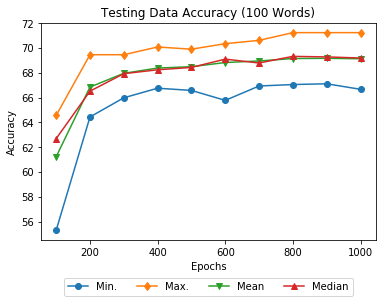

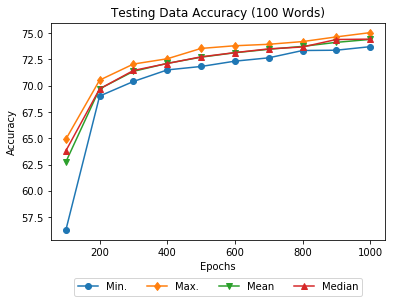

In [15]:
plt.plot(test_table[:,0], test_table[:,[1]], label="Min.", marker="o")
plt.plot(test_table[:,0], test_table[:,[2]], label="Max.", marker="d")
plt.plot(test_table[:,0], test_table[:,[3]], label="Mean", marker="v")
plt.plot(test_table[:,0], test_table[:,[4]], label="Median", marker="^")
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title("Testing Data Accuracy ({0} Words)".format(num_words))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(train_table[:,0], train_table[:,[1]], label="Min.", marker="o")
plt.plot(train_table[:,0], train_table[:,[2]], label="Max.", marker="d")
plt.plot(train_table[:,0], train_table[:,[3]], label="Mean", marker="v")
plt.plot(train_table[:,0], train_table[:,[4]], label="Median", marker="^")
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title("Testing Data Accuracy ({0} Words)".format(num_words))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# References


[1] Generative Adversarial Networks
Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio

https://arxiv.org/abs/1406.2661

<!--bibtex

@ENTRY TYPE{CITATION ID,
    FIELD 1 = {source specific information},
    FIELD 2 = {source specific informatio},
    FIEL 3 = {source specific informatio},
    FIELD 4 = {source specific informatio}
}

-->

<!--bibtex

@ENTRY TYPE{CITATION ID,
    FIELD 1 = {source specific information},
    FIELD 2 = {source specific informatio},
    FIEL 3 = {source specific informatio},
    FIELD 4 = {source specific informatio}
}

-->

<!--bibtex

@inproceedings{goodfellow2014generative,
  title={Generative adversarial nets},
  author={Goodfellow, Ian and Pouget-Abadie, Jean and Mirza, Mehdi and Xu, Bing and Warde-Farley, David and Ozair, Sherjil and Courville, Aaron and Bengio, Yoshua},
  booktitle={Advances in neural information processing systems},
  pages={2672--2680},
  year={2014}
}

-->